# Semantic Search Engine using ANNs & Recommender System

This project focuses on exploring and implementing advanced concepts and techniques in information retrieval and recommender systems. The primary objectives are to develop a semantic search engine using Artificial Neural Networks (ANNs), explore alternative models for text search, and design a recommender system based on lecture transcripts.

# Note: This project was completed on COLAB, therefore MovieLens dataset direcotry is set to google drive. If need to run on local please update `MOVIELENS_DIR` variable. Thanks!

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Name

Sofia Jia

# Part 1: Setting up the libraries and environment

In [2]:
!pip install annoy

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Part 2: Semantic Search using ANN for Text-to-Text with Annoy

Creating vector embeddings for text documents using an ANN typically involves using a pre-trained model like BERT or RoBERTa. These models are trained on large corpora of text and learn to represent words and sentences in high-dimensional vector spaces. 

The process includes tokenizing the text, passing it through the neural network, and extracting the output from one of the intermediate layers, usually the final hidden layer. The resulting vectors (embeddings) capture the semantic meaning of the text, as words with similar meanings will have similar vector representations. This allows the model to understand context and relationships between words beyond simple word matching.

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch

def generate_embeddings(texts, model_name='bert-base-uncased'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return embeddings

In [5]:
texts = ["Hello, world!", "Text embeddings with BERT"]
embeddings = generate_embeddings(texts)
print(embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[array([-1.09896637e-01,  8.57999325e-02,  3.69180590e-01, -3.12601686e-01,
        2.99345050e-02,  1.03398621e-01,  6.78497314e-01,  6.07466698e-01,
       -2.23461673e-01, -5.25851607e-01,  3.22315395e-02, -5.43798387e-01,
       -2.63345271e-01,  5.34970760e-01, -5.04805505e-01,  3.43896419e-01,
       -8.81888270e-02,  5.56264967e-02,  3.82663347e-02,  3.19965959e-01,
       -7.96963871e-02,  5.77588268e-02,  1.95493639e-01,  2.32307255e-01,
        2.27892876e-01, -2.37955406e-01, -2.84697652e-01,  2.14525640e-01,
       -1.62211522e-01, -1.60442397e-01, -3.02115679e-01, -1.34756565e-02,
       -9.24539659e-03,  2.53668636e-01, -7.05440581e-01,  1.08777487e-03,
       -1.70073390e-01,  4.54443902e-01, -6.03380978e-01, -1.43333614e-01,
       -2.33441457e-01, -6.79750860e-01,  3.65103960e-01,  1.60454974e-01,
        1.00359626e-01, -7.11502016e-01, -2.11680040e-01,  1.37596235e-01,
       -4.86077875e-01, -1.30422413e-02,  1.85114503e-01,  4.91788864e-01,
       -2.81667948e-01, 

**Note: ** The Annoy library is used to store and retrieve high-dimensional vector embeddings efficiently. It builds a forest of binary trees to partition the vector space, allowing for approximate nearest neighbor searches in sublinear time.
For example, the `most_similar()` function calls of Word2Vec, Doc2Vec, FastText and Word2VecKeyedVectors model for fast vector retrieval.

In [6]:
from annoy import AnnoyIndex
import numpy as np

def build_annoy_index(embeddings, n_trees=10, metric='angular'):
    dimension = len(embeddings[0])

    # build the Annoy index using AnnoyIndex() function
    annoy_index = AnnoyIndex(dimension, metric)
    for i, emb in enumerate(embeddings):
        annoy_index.add_item(i, emb)
    annoy_index.build(n_trees)
    return annoy_index

In [7]:
annoy_index = build_annoy_index(embeddings)
print(annoy_index.get_nns_by_item(0, 5))

[0, 1]


**Note: ** Performing a semantic search with Annoy involves querying the index with a vector representation of the query text. The Annoy index returns the closest items based on the vector similarity.

In [8]:
# Semantic search function
def semantic_search(query, annoy_index, texts, model_name='bert-base-uncased', top_k=5):
    query_embedding = generate_embeddings([query], model_name=model_name)[0]
    indices = annoy_index.get_nns_by_vector(query_embedding, top_k)
    results = [texts[i] for i in indices if i < len(texts)]  # Ensure valid indices
    return results

query = "Hello"
results = semantic_search(query, annoy_index, texts)
print(results)

['Hello, world!', 'Text embeddings with BERT']


# Part 3: Searching Images with Text

In [9]:
%%bash
# Uncomment this if using it for the first time. -qqq for ZERO-OUT
pip3 -qqq install transformers torch datasets

# The following two libraries avoid the UnidentifiedImageError
pip3 -qqq install gdcm
pip3 -qqq install pydicom
pip -qqq install faiss-gpu
pip -qqq install pinecone-client

# # Uncomment this if using it for the first time. -pip3 -qqq for ZERO-OUT
# !pip -qqq install transformers torch datasets

# # The following two libraries avoid the UnidentifiedImageError
# !pip3 -qqq install gdcm
# !pip3 -qqq install pydicom
# !pip -qqq install faiss-gpu
# !pip -qqq install pinecone-client

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [10]:
!pip install pyarrow==11.0.0

  Using cached pyarrow-11.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.9 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 16.1.0
    Uninstalling pyarrow-16.1.0:
      Successfully uninstalled pyarrow-16.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 11.0.0 which is incompatible.
datasets 2.20.0 requires pyarrow>=15.0.0, but you have pyarrow 11.0.0 which is incompatible.


In [11]:
import os
import faiss
import torch
import skimage
import requests
import pinecone
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

In [12]:
# Get the dataset
image_data = load_dataset("conceptual_captions", split="train")

In [13]:
image_data_df = pd.DataFrame(image_data)

# Limit the dataset to the first 100 entries (or any other number)
limited_image_data_df = image_data_df.head(100)

# Define functions
def check_valid_URLs(image_URL):
    try:
        response = requests.get(image_URL)
        Image.open(BytesIO(response.content))
        return True
    except:
        return False

def get_image(image_URL):
    response = requests.get(image_URL)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    return image

# Apply functions to the limited DataFrame
limited_image_data_df["is_valid"] = limited_image_data_df["image_url"].apply(check_valid_URLs)

# Filter valid URLs
limited_image_data_df = limited_image_data_df[limited_image_data_df["is_valid"] == True]

# Get images from valid URLs
limited_image_data_df["image"] = limited_image_data_df["image_url"].apply(get_image)

# Display the limited DataFrame
print(limited_image_data_df)

<ipython-input-13-67643445efbf>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_image_data_df["is_valid"] = limited_image_data_df["image_url"].apply(check_valid_URLs)
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


                                            image_url  \
0   http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...   
1   http://78.media.tumblr.com/3b133294bdc7c7784b7...   
3   https://thumb1.shutterstock.com/display_pic_wi...   
4   https://thumb1.shutterstock.com/display_pic_wi...   
6   https://prismpub.com/wp-content/uploads/2016/1...   
..                                                ...   
94  http://l7.alamy.com/zooms/476f507779b646c4b9ae...   
95  https://i.pinimg.com/736x/83/ab/4f/83ab4fbbb6a...   
96  https://i.pinimg.com/736x/58/2a/ec/582aecd2587...   
98  https://ak8.picdn.net/shutterstock/videos/5281...   
99  https://burpple-1.imgix.net/foods/2cb7a04812e4...   

                                              caption  is_valid  \
0                          a very typical bus station      True   
1   sierra looked stunning in this top and this sk...      True   
3   interior design of modern living room with fir...      True   
4     cybernetic scene isolated on white backgr

In [14]:
def get_model_info(model_ID, device):
# Save the model to device
	model = CLIPModel.from_pretrained(model_ID).to(device)
 	# Get the processor
	processor = CLIPProcessor.from_pretrained(model_ID)
# Get the tokenizer
	tokenizer = CLIPTokenizer.from_pretrained(model_ID)
# Return model, processor & tokenizer
	return model, processor, tokenizer

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Define the model ID
model_ID = "openai/clip-vit-base-patch32"
# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)

In [15]:
def get_single_text_embedding(text):
  inputs = tokenizer(text, return_tensors = "pt")
  text_embeddings = model.get_text_features(**inputs)
 	# convert the embeddings to numpy array
  embedding_as_np = text_embeddings.cpu().detach().numpy()
  return embedding_as_np

def get_all_text_embeddings(df, text_col):
  df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)
  return df


# Apply the functions to the dataset
limited_image_data_df = get_all_text_embeddings(limited_image_data_df, "caption")

In [16]:
def get_single_image_embedding(my_image):
    image = processor(
        text=None,
        images=my_image,
        return_tensors="pt"
    )["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np

In [17]:
def get_all_images_embedding(df, img_column):
    df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)
    return df

limited_image_data_df = get_all_images_embedding(limited_image_data_df, "image")

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top_N_images(query, data, top_K=4, search_criterion="text"):
   # Text to image Search
   if(search_criterion.lower() == "text"):
     query_vect = get_single_text_embedding(query)
   # Image to image Search
   else:
     query_vect = get_single_image_embedding(query)
   # Relevant columns
   revevant_cols = ["caption", "image", "cos_sim"]
   # Run similarity Search
   data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))# line 17
   data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
   """
   Retrieve top_K (4 is default value) articles similar to the query
   """
   most_similar_articles = data.sort_values(by='cos_sim',  ascending=False)[1:top_K+1] # line 24
   return most_similar_articles[revevant_cols].reset_index()

In [19]:
# helper function to display result images
def plot_images_by_side(top_images):
 index_values = list(top_images.index.values)
 list_images = [top_images.iloc[idx].image for idx in index_values]
 list_captions = [top_images.iloc[idx].caption for idx in index_values]
 similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]
 n_row = n_col = 2
 _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
 axs = axs.flatten()

 for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
     ax.imshow(img)
     sim_score = 100*float("{:.2f}".format(sim_score))
     ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
 plt.show()

Query: all shots by by person and rider shots can be found on his website .


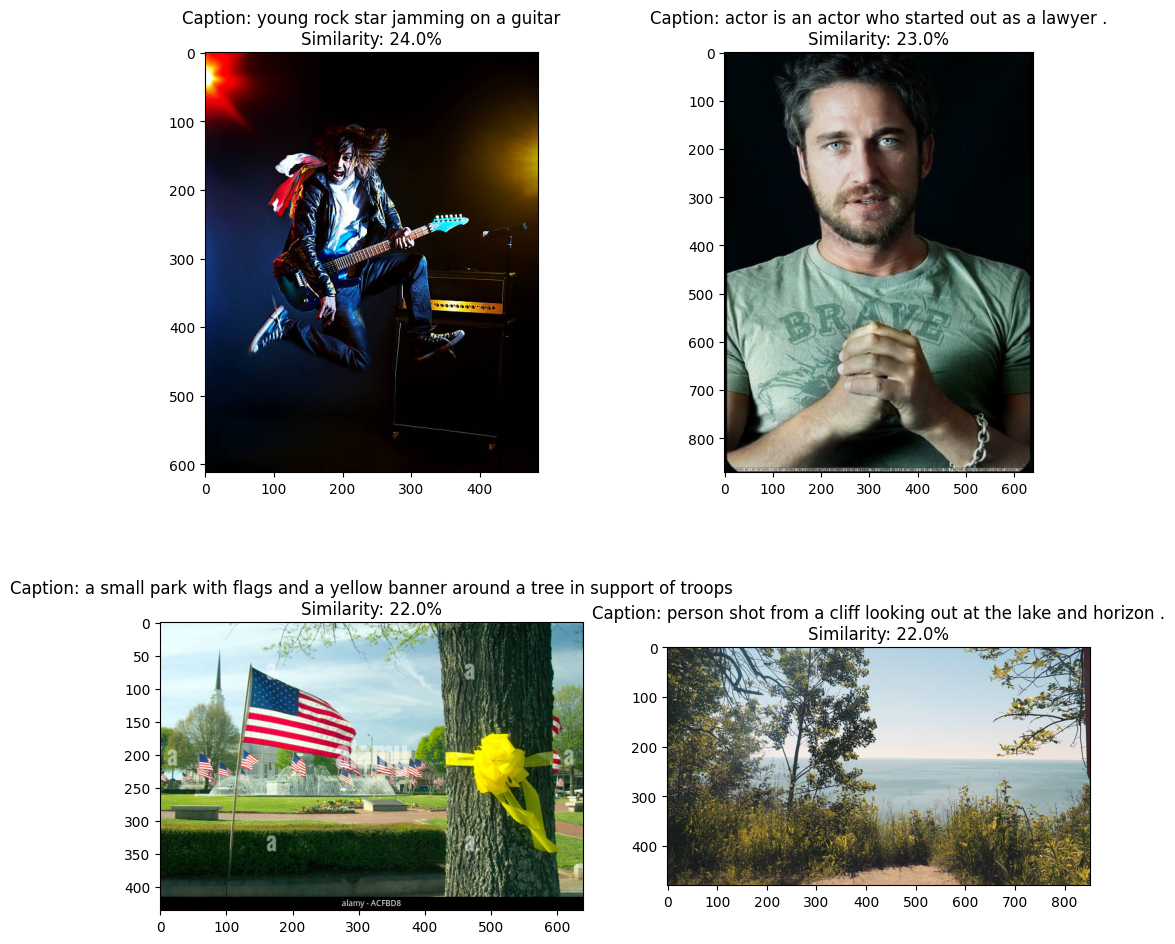

In [20]:
query_caption = limited_image_data_df.iloc[10].caption
# Print the original query text
print("Query: {}".format(query_caption))
# Run the similarity search
top_images = get_top_N_images(query_caption, limited_image_data_df)
# Plot the recommended images
plot_images_by_side(top_images)

The apporach from the tutorial provided simplicity and clarity, but it has a very limited scope as it might focus solely on embedding extraction. On the other hand, pinecone CLIP image search approach provides a scalable vector database, which is designed to handle large-scale datasets efficiently. This is ideal for production-level deployments. However, the integration with Pinecone and understanding its advanced features might be complex for beginners or those not familiar with vector databases.

# Part 4: Recommender System

**Note: ** First, a profile need to be built for each item using TF-IDF, each profile contains important metadata information. Then a user profile is built. The user profile is a vector that describes the user preference.

During the creation of the user’s profile, we use a utility matrix that describes the relationship between user and item. From this information, the best estimate we can decide which item the user likes, is some aggregation of the profiles of those items.

In [21]:
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

warnings.simplefilter(action='ignore', category=FutureWarning)

In [22]:
def normalize_ratings(ratings):
    scaler = StandardScaler()
    ratings[['rating']] = scaler.fit_transform(ratings[['rating']])
    return ratings

def normalize_user_freq(user_freq):
    scaler = StandardScaler()
    user_freq[['n_ratings']] = scaler.fit_transform(user_freq[['n_ratings']])
    return user_freq

# loading rating dataset
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")

# normalize ratings
ratings = normalize_ratings(ratings)
print(ratings.head())

# loading movie dataset
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
print(movies.head())

# user frequency
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']

# normalize user frequency
user_freq = normalize_user_freq(user_freq)
print(user_freq.head())

   userId  movieId    rating  timestamp
0       1        1  0.478112  964982703
1       1        3  0.478112  964981247
2       1        6  0.478112  964982224
3       1       47  1.437322  964983815
4       1       50  1.437322  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  n_ratings
0       1   0.247698
1       2  -0.506221
2       3  -0.469082
3       4   0.188276
4       5  -0.450513


In [23]:
# create user-item matrix using scipy csr matrix
def create_matrix(df):

	N = len(df['userId'].unique())
	M = len(df['movieId'].unique())

	# map Ids to indices
	user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
	movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))

	# map indices to IDs
	user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
	movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))

	user_index = [user_mapper[i] for i in df['userId']]
	movie_index = [movie_mapper[i] for i in df['movieId']]

	X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))

	return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)


In [49]:
# find similar movies using KNN
def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):

	neighbour_ids = []

	movie_ind = movie_mapper[movie_id]
	movie_vec = X[movie_ind]
	k+=1
	kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
	kNN.fit(X)
	movie_vec = movie_vec.reshape(1,-1)
	neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
	for i in range(0,k):
		n = neighbour.item(i)
		neighbour_ids.append(movie_inv_mapper[n])
	neighbour_ids.pop(0)
	return neighbour_ids


In [50]:
def evaluate_recommender_system(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10):
	df1 = ratings[ratings['userId'] == user_id]

	if df1.empty:
		print(f"User with ID {user_id} does not exist.")
		return

	movie_id = df1[df1['rating'] == max(df1['rating'])]['movieId'].iloc[0]

	movie_titles = dict(zip(movies['movieId'], movies['title']))

	similar_ids = find_similar_movies(movie_id, X, k)
	movie_title = movie_titles.get(movie_id, "Movie not found")

	if movie_title == "Movie not found":
		print(f"Movie with ID {movie_id} not found.")
		return

	print(f"Since you watched {movie_title}, you might also like:")
	for i in similar_ids:
		print(movie_titles.get(i, "Movie not found"))

# sample user id
user_id = 150
evaluate_recommender_system(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10)


Since you watched Twelve Monkeys (a.k.a. 12 Monkeys) (1995), you might also like:
Pulp Fiction (1994)
Trainspotting (1996)
Brazil (1985)
Full Metal Jacket (1987)
Seven (a.k.a. Se7en) (1995)
Usual Suspects, The (1995)
Unforgiven (1992)
Shawshank Redemption, The (1994)
Fight Club (1999)
Reservoir Dogs (1992)


The strength of this implementation is that there's no need for data on other users when applying to similar users and it's able to recommend to users with unique tastes.
The weakness is finding the appropriate feature is difficult and it doesn’t recommend items outside the user profile.

# Part 5: Collaborative Filtering

**Note: ** Collaborative Filtering recommends items based on similarity measures between users and/or items. The basic assumption behind the algorithm is that users with similar interests have common preferences.On the other hand, content-based filtering recommends items based on the attributes of items a user has liked.

In [51]:
!unzip /content/drive/MyDrive/ml-100k.zip -d .

Archive:  /content/drive/MyDrive/ml-100k.zip
replace ./ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [55]:
MOVIELENS_DIR = "ml-100k/" # if need to run on local please update the path

In [57]:
fields = ['userID', 'itemID', 'rating', 'timestamp']
ratingDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.data'), sep='\t', names=fields)

ratingDF.head()

numUsers = len(ratingDF.userID.unique())
numItems = len(ratingDF.itemID.unique())

print("Number of users:", numUsers)
print("Number of items:", numItems)

fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

trainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u1.base'), sep='\t', names=fields)
testDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u1.test'), sep='\t', names=fields)

# test number of records (total should be 100K)
print("# of lines in train:", trainDF.shape[0])
print("# of lines in test:", testDF.shape[0])


moviesDF.head()


Number of users: 943
Number of items: 1682
# of lines in train: 80000
# of lines in test: 20000


,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [58]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
    INPUT:
        rating_df: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
        num_users: int. number of users
        num_items: int. number of items

    OUTPUT:
        matrix: 2D numpy array.
    """
    # Initialize the matrix with zeros
    matrix = np.zeros((num_users, num_items))

    # Populate the matrix with ratings from the DataFrame
    for row in rating_df.itertuples():
        user_id = row.userID - 1  # Assuming userID starts from 1
        item_id = row.itemID - 1  # Assuming itemID starts from 1
        rating = row.rating
        matrix[user_id, item_id] = rating

    return matrix



In [59]:
user_item_matrix = dataPreprocessor(ratingDF, numUsers, numItems)
print(user_item_matrix)

[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


The function first initializes a matrix with 0s based on the number of users and items. It then iterates through the rating DataFrame, adjusting user and item IDs to zero-based indices, and populates the matrix with the corresponding ratings. Finally, the populated user-item matrix is returned for further analysis or use in a recommender system.

In [60]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def dataPreprocessor(rating_df, num_users, num_items):
    """
    INPUT:
        rating_df: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
        num_users: int. number of users
        num_items: int. number of items

    OUTPUT:
        matrix: 2D numpy array.
    """
    matrix = np.zeros((num_users, num_items))
    for row in rating_df.itertuples():
        user_id = row.userID - 1  # Assuming userID starts from 1
        item_id = row.itemID - 1  # Assuming itemID starts from 1
        rating = row.rating
        matrix[user_id, item_id] = rating
    return matrix

class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name

    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        return switcher[method_name]

    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'
        """
        predictionMatrix = np.zeros((num_users, num_items))
        for user in range(num_users):
            user_ratings = train_matrix[user, :]
            avg_rating = user_ratings[user_ratings > 0].mean() if user_ratings[user_ratings > 0].size > 0 else 0
            predictionMatrix[user, :] = avg_rating
        return predictionMatrix

    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'
        """
        predictionMatrix = np.zeros((num_users, num_items))
        item_popularity = train_matrix.sum(axis=0)
        most_popular = np.argsort(item_popularity)[::-1]
        avg_popularity = item_popularity.mean() if item_popularity.size > 0 else 0
        predictionMatrix[:, most_popular] = avg_popularity
        return predictionMatrix

    def predict_all(self, train_df, num_users, num_items):
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)

    def evaluate_test(self, test_df, copy=False):
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df

        prediction[self.pred_column_name] = np.nan

        for (index, userID, itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction

    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")


This function generates recommendations based on either popularity or user average methods. For popularity-based recommendations, it ranks items according to their overall popularity among users, assuming more popular items are generally preferred.

Both methods leverage the predict_all function to compute predictions using a processed user-item matrix `train_matrix`, which is then evaluated against test data `test_df `to assess recommendation accuracy.

In [61]:
rec_sys = BaseLineRecSys(method='useraverage')
rec_sys.predict_all(trainDF, numUsers, numItems)

# evaluate on test data
predictions = rec_sys.evaluate_test(testDF)

print(predictions.head())

20000it [00:03, 5570.27it/s]

   userID  itemID  rating  timestamp  useraverage
0       1       6       5  887431973     3.681481
1       1      10       3  875693118     3.681481
2       1      12       5  878542960     3.681481
3       1      14       5  874965706     3.681481
4       1      17       3  875073198     3.681481


User based collaborative filtering excels in personalizing recommendations based on similar user behaviors but struggles with scalability and cold start issues.

Item-based collaborative filtering offers stability in recommendations over time and handles sparse data better, yet it may provide less personalized suggestions compared to user-based methods.

# References

*   https://www.kaggle.com/code/yashsrivastava51213/semantic-searching-with-annoy-nlp
*   https://www.activeloop.ai/resources/glossary/annoy-approximate-nearest-neighbors-oh-yeah/#:~:text=Annoy%20works%20by%20constructing%20a,useful%20for%20large-scale%20applications.
*   https://www.pinecone.io/learn/clip-image-search/
*   https://www.geeksforgeeks.org/recommendation-system-in-python/

